In [28]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [29]:
import tensorflow as tf

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [31]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [32]:
# Retrieve the images : 
# You can use an archive of creative-commons licensed flower photos from Google.

import pathlib
data_dir = tf.keras.utils.get_file(
                      origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                      fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [33]:
data_dir


WindowsPath('C:/Users/pc/.keras/datasets/flower_photos')

In [34]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [35]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

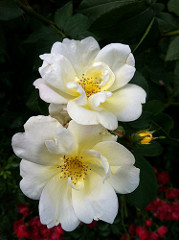

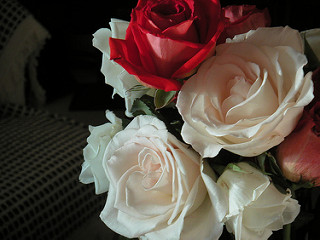

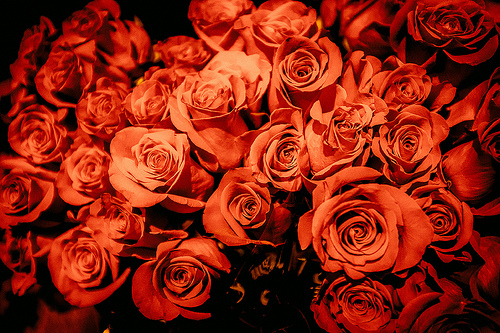

In [36]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [62]:
# Load using keras.preprocessing
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [63]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [64]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='training')

Found 2939 images belonging to 5 classes.


In [65]:
val_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='validation')

Found 731 images belonging to 5 classes.


In [41]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [50]:
image_batch, label_batch = next(train_data_gen)
# show_batch(image_batch, label_batch)
print((image_batch.shape, image_batch.dtype),(label_batch.shape, label_batch.dtype))

((32, 224, 224, 3), dtype('float32')) ((32, 5), dtype('float32'))


In [73]:
np.random.seed(20160704)
tf.set_random_seed(20160704)

x  = tf.placeholder(tf.float32, name="x")     # 224 x 224

"""**[CNN-03]** 첫 번째 단계의 합성곱 필터와 풀링 계층을 정의한다."""
num_filters1 = 32
# Cin:3  Cout: num_filters1
W_conv1 = tf.Variable(tf.truncated_normal([5,5,3,num_filters1], stddev=0.1))
h_conv1 = tf.nn.conv2d(x, W_conv1, strides=[1,1,1,1], padding='SAME', name='h_conv1')
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 - b_conv1, name='h_conv1_cutoff') 

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  # 112 x 112

"""**[CNN-04]** 두 번째 단계의 합성곱 필터와 풀링 계층을 정의한다."""
num_filters2 = 32
W_conv2 = tf.Variable(tf.truncated_normal([5,5,num_filters1,num_filters2], stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME', name='h_conv2')
b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 - b_conv2, name='h_conv2_cutoff')

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  # 56 x 56

"""**[CNN-05]** 전 결합층, 드롭아웃 계층, 소프트맥스 함수를 정의한다."""
h_pool2_flat = tf.reshape(h_pool2, [-1, 56*56*num_filters2])

num_units1 = 56*56*num_filters2
num_units2 = 32
w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32, name="keep_prob")
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 5]))
b0 = tf.Variable(tf.zeros([5]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0, name="p")
# p = tf.identity(p, "p")

"""**[CNN-06]** 오차 함수 loss, 트레이닝 알고리즘 train_step, 정답률 accuracy을 정의한다."""
t = tf.placeholder(tf.float32, [None, 5])
loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=p, labels=t))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [74]:
"""**[CNN-07]** 세션을 준비하고 Variable을 초기화한다."""
# sess = tf.InteractiveSession()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

"""**[CNN-08]** 파라미터 최적화."""
batch_size = 100
num_epochs = 100
num_iterations = int(image_count / batch_size)
print("num_iterations = %d" %(num_iterations))

epoch = 0
i = 0
for _ in range(num_epochs):
    epoch += 1
    avg_loss = 0 
    avg_accuracy = 0
    
    for iteration in range (num_iterations):
      i += 1
      image_batch, label_batch = next(train_data_gen)
      _, loss_val, acc_val = sess.run([train_step, loss, accuracy],
                                      feed_dict={x: image_batch,
                                                 t: label_batch,
                                                 keep_prob:0.8
                                                }
                                     )
      avg_loss += loss_val / num_iterations
      avg_accuracy += acc_val / num_iterations
      
      if i % 500 == 0:
          test_images, test_labels = next(val_data_gen)
          loss_val, acc_val = sess.run([loss, accuracy],
                                       feed_dict={x: test_images,
                                                  t: test_labels,
                                                  keep_prob:1.0
                                                 }
                                      )
          print ('==> Step: %d, (Test Data) Loss: %f, Accuracy: %f' % (i, loss_val, acc_val))
          saver.save(sess, 'data/cnn_session', global_step=i)
      
    print("Epoch  :  %04d, (train Data) Loss: %0.9f,  Accuracy: %0.9f" %(epoch, avg_loss, avg_accuracy))
print("Learning Finished")

#Test model and check accuracy
print(" Accuracy for Test Data:", sess.run(accuracy,
                                            feed_dict={x: test_images,
                                                       t: test_labels,
                                                       keep_prob:1.0
                                                      }
                                           )
     )

num_iterations = 36
Epoch  :  0001, (train Data) Loss: 1.588308656,  Accuracy: 0.273855453
Epoch  :  0002, (train Data) Loss: 1.549029367,  Accuracy: 0.340277778
Epoch  :  0003, (train Data) Loss: 1.526128600,  Accuracy: 0.366737397
Epoch  :  0004, (train Data) Loss: 1.498496109,  Accuracy: 0.368055556
Epoch  :  0005, (train Data) Loss: 1.486967461,  Accuracy: 0.394097222
Epoch  :  0006, (train Data) Loss: 1.459029777,  Accuracy: 0.435088735
Epoch  :  0007, (train Data) Loss: 1.459854583,  Accuracy: 0.428819444
Epoch  :  0008, (train Data) Loss: 1.431823207,  Accuracy: 0.452256944
Epoch  :  0009, (train Data) Loss: 1.437878499,  Accuracy: 0.456082819
Epoch  :  0010, (train Data) Loss: 1.424253444,  Accuracy: 0.466145833
Epoch  :  0011, (train Data) Loss: 1.382013943,  Accuracy: 0.512988683
Epoch  :  0012, (train Data) Loss: 1.396371474,  Accuracy: 0.500868056
Epoch  :  0013, (train Data) Loss: 1.409208867,  Accuracy: 0.487847222
==> Step: 500, (Test Data) Loss: 1.423802, Accuracy: 0.50

In [84]:
def show_comparison(image_batch, label_batch, logits):
  plt.figure(figsize=(10,10))
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title('Label: ' + CLASS_NAMES[np.argmax(label_batch, axis=1)[n]].title() + '\n' +
                'Output: ' + CLASS_NAMES[np.argmax(logits, axis=1)[n]].title())
      plt.axis('off')

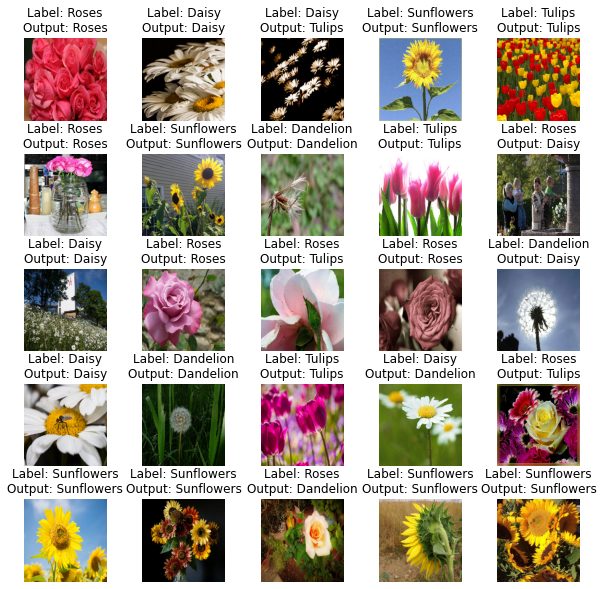

In [85]:
logits = sess.run(p, feed_dict={x: test_images,
                                t: test_labels,
                                keep_prob:1.0
                               }
                 )
show_comparison(test_images, test_labels, logits)